# Исследование поведения пользователей сервиса аренды самокатов

**Описание проекта**. GoFast — сервис аренды электросамокатов, в мобильном приложении которого есть два тарифных плана: без подписки и по подписке *Ultra*. Предполагается, что подписка *Ultra* принесет выгоду компании. Прежде чем начать работать в сторону увеличения количества пользователей с подпиской, необходимо было выяснить, действительно ли такие пользователи выгодны для компании. 

Для исследования были доступны данные о некоторых пользователях из нескольких городов, а также об их поездках и подписках. Рассматриваются ключевые показатели: длительность и расстояние поездок пользователей с разными типами подписки, а также выручка, которую они приносят компании ежемесячно. 

## 1. Загрузка данных

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import math

from datetime import datetime
from scipy import stats as st

In [2]:
# загружаем нужные данные 
users = pd.read_csv('C:/Users/alkon/practicum_projects/scooter_project/users_go.csv')
rides = pd.read_csv('C:/Users/alkon/practicum_projects/scooter_project/rides_go.csv')
subscriptions = pd.read_csv('C:/Users/alkon/practicum_projects/scooter_project/subscriptions_go.csv')

Посмотрим, как выглядит датафрейм с данными о **пользователях**:

In [3]:
# посмотрим информацию о датафрейме
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
# выведем первые строки
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


В датафрейме есть столбец с `user_id`— уникальными идентификаторами пользователя, каждому из которых соответствует имя, возраст, город и тип подписки. Всего 1536 записей, пропуски отсутствуют. Типы данных корректные, однако информацию о типе подписки можно было бы записывать не как строки (ultra или free), а как булево значение: нет подписки — 0, есть подписка — 1. Поскольку записей не так много, в рамках данного исследования оставим это как есть. 

Теперь с данными о **поездках**: 

In [5]:
# посмотрим информацию о датафрейме
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
# выведем первые строки
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Здесь находятся данные о поездках пользователей. Для каждой поездки есть информация о `user_id`, расстоянии в метрах, длительности в минутах и дате поездки. Всего 18068 записей, пропуски отсутствуют. Тип данных в столбце с датой необходимо будет заменить на формат даты Pandas для возможности обработки и фильтрации по месяцам. Остальные типы данных в датафрейме корректны. 

Теперь посмотрим на датафрейм с данными о **подписках**:

In [7]:
# посмотрим информацию о датафрейме
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [8]:
# выведем первые строки
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Всего 2 строки для двух типов подписки (`free` и `ultra`) и столбцы с информацией по тарифному плану. Для бесплатной подписки стартовая цена поездки 50 рублей, стоимость минуты 8 рублей. Для подписки Ultra стоимость минуты 6 рублей, старт — бесплатно. Стоимость подписки на месяц — 199 рублей. Эти данные понадобятся нам для расчёта ежемесячной выручки. Типы данных корректные.

## 2. Предобработка данных

Приведем столбец `date` к типу даты Pandas.

In [9]:
# приведем столбец к нужному формату с помощью функции Pandas to_datetime()
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Создадим новый столбец с номером месяца на основе столбца `date`.

In [10]:
# создадим новый столбец
rides['month'] = rides['date'].dt.month

In [11]:
display(pd.DataFrame({'Дата первой поездки' : [rides['date'].min().strftime('%d-%m-%Y')],
                      'Дата последней поездки' : [rides['date'].max().strftime('%d-%m-%Y')]}))

,Дата первой поездки,Дата последней поездки
0,01-01-2021,30-12-2021


У нас имеются данные о поездках пользователей с января по декабрь 2021 года. 

##### Обработка дубликатов и пропусков

In [12]:
# проверим, есть ли дубликаты в датафрейме 'users'
users.duplicated().sum()

31

In [13]:
# удалим явные дубликаты
users = users.drop_duplicates()
# и проверим результат
users.duplicated().sum()

0

In [14]:
# проверим, есть ли дубликаты в датафрейме 'rides'
rides.duplicated().sum()

0

In [15]:
# проверим, есть ли дубликаты в датафрейме 'subscriptions'
subscriptions.duplicated().sum()

0

Перейдем к обработке пропусков. 

In [16]:
# посчитаем количество пропусков в датафрейме 'users'
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [17]:
# посчитаем количество пропусков в датафрейме 'rides'
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [18]:
# посчитаем количество пропусков в датафрейме 'subscriptions'
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

##### Поиск аномальных значений

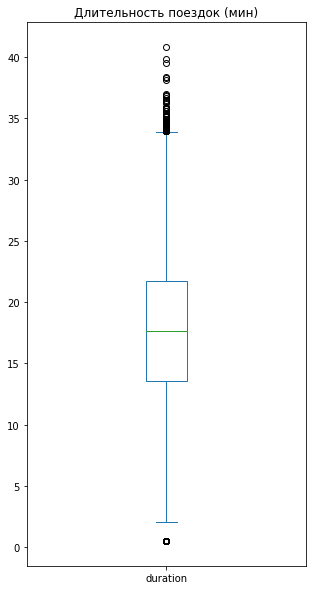

In [19]:
# посмотрим на распределение данных
rides['duration'].plot(kind='box',figsize=(5,10))
plt.title('Длительность поездок (мин)')
plt.show()

Данные выглядят нормально. Длинные поездки сгруппированы как выбросы в диапазоне от ~34 до ~ 42 минут. Есть выбросы в виде очень коротких поездок — возможно, это отмененные поездки.

In [20]:
# посмотрим, какое расстояние соответствует поездкам до 1 минуты
rides.loc[rides['duration'] < 2,'distance'].sort_values()

15132    4030.308008
17909    4103.998874
10692    4106.278268
9698     4169.066800
14342    4177.139336
            ...     
14574    6316.574814
13701    6414.516026
11385    6601.197575
17242    6724.932981
16309    7211.007745
Name: distance, Length: 95, dtype: float64

Есть поездки, в которых менее чем за 1 минуту проехали 4-7 км, это очень большая скорость. Т.е. в датасете есть строки с аномально большой скоростью поездки. Обработаем эти строки. Будем ориентироваться на законодательное ограничение в максимальную скорость 25 км/ч для электросамокатов.

In [21]:
# добавим столбец с расчетом скорости
rides['speed'] = rides['distance'] / rides['duration']

# для удобства из м/мин переведём в км/ч
rides['speed'] = rides['speed'] * 0.06

# посчитаем, сколько поездок превышают ограничение, добавив погрешность в 0.5 км/ч
# можно изменять границу фильтрации до большего числа и дальше и убедиться, что это чёткий выброс по скорости
rides[rides['speed'] > 25.5].sort_values('duration')

,user_id,distance,duration,date,month,speed
6531,701,4196.445201,0.5,2021-08-31,8,503.573424
14615,1287,5944.789947,0.5,2021-12-09,12,713.374794
14574,1285,6316.574814,0.5,2021-09-25,9,757.988978
14417,1273,4178.876258,0.5,2021-04-30,4,501.465151
14342,1268,4177.139336,0.5,2021-06-09,6,501.256720
...,...,...,...,...,...,...
9581,928,4857.412920,0.5,2021-06-06,6,582.889550
9497,922,4620.899239,0.5,2021-01-05,1,554.507909
9282,907,4520.123807,0.5,2021-04-24,4,542.414857
10426,987,5375.139265,0.5,2021-03-16,3,645.016712


Видим, что есть 95 поездок с аномально высокой скоростью. В том, что это ошибочные строки, нас убеждает и одинаковая длительность поездки в 30 секунд. Это меньше 1% строк для данного датасета, поэтому просто удалим их.

In [22]:
# отфильтруем датасет
rides = rides.loc[rides['speed'] <= 25.5]

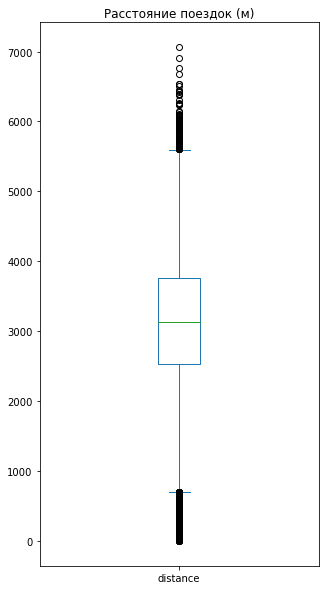

In [23]:
# посмотрим на распределение данных
rides['distance'].plot(kind='box',figsize=(5,10))
plt.title('Расстояние поездок (м)')
plt.show()

Здесь также длинные поездки ~6-7 км и короткие поездки до ~1 км — сгруппированные выбросы. При этом данные выглядят правдоподобно и нормально: такие расстояния вполне можно проехать на электросамокате.

In [24]:
# для удобства округлим данные до двух знаков после запятой
rides['duration'] = rides['duration'].round(2)
rides['distance'] = rides['distance'].round(2)

In [25]:
rides.head()

,user_id,distance,duration,date,month,speed
0,1,4409.92,25.60,2021-01-01,1,10.335841
1,1,2617.59,15.82,2021-01-18,1,9.929620
2,1,754.16,6.23,2021-04-20,4,7.260713
3,1,2694.78,18.51,2021-08-11,8,8.734644
4,1,4028.69,26.27,2021-08-28,8,9.202888


**Вывод**. В ходе предобработки данных были выявлены и удалены строки явные дубликаты (31) в датафрейме `users`. Обнаружены и удалены строки (менее 1% от всех строк в `rides`) с аномально высокой скоростью больше 25.5 км/ч. 

## 3. Исследовательский анализ данных

##### Частота встречаемости городов

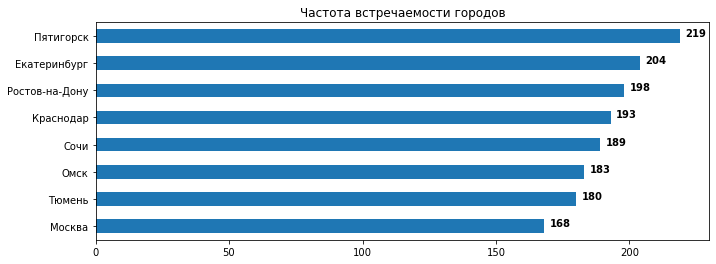

In [26]:
# визуализируем частоту встречаемости городов с помощью столбчатой диаграммы
city_counts = users['city'].value_counts().sort_values()
city_counts.plot.barh(figsize=(11,4))

for i, v in enumerate(city_counts):
    plt.text(v + 2, i, str(v), color='black', fontweight='bold')

plt.title('Частота встречаемости городов')
plt.show()

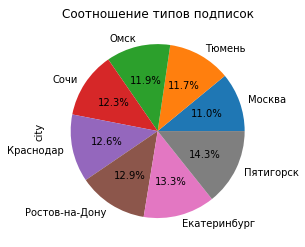

In [27]:
# визуализируем круговой диаграммой
city_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Соотношение типов подписок')
plt.show()

В наборе данных представлены Пятигорск, Екатеринбург, Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень и Москва. Чаще всего в данных встречается Пятигорск (14.3%), реже всего — Москва (11.0%). 

##### Соотношение пользователей с подпиской и без подписки

In [28]:
# посмотрим, сколько пользователей с подпиской и без
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

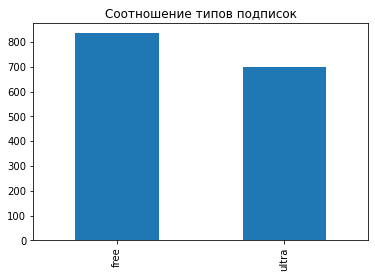

free     54.4
ultra    45.6
Name: subscription_type, dtype: float64


In [29]:
# визуализируем соотношение пользователей с подпиской и без с помощью столбчатой диаграммы
users['subscription_type'].value_counts().plot.bar()
plt.title('Соотношение типов подписок')
plt.show()

# и посчитаем процентное соотношение
print((users['subscription_type'].value_counts() / len(users) * 100).round(1))

# еще можно было визуализировать круговой диаграммой
# users['subscription_type'].value_counts().plot(kind='pie')

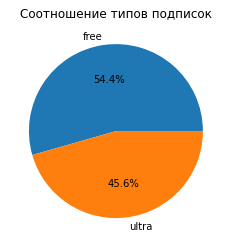

In [30]:
# визуализируем круговой диаграммой
users['subscription_type'].value_counts().plot(kind='pie', autopct='%1.1f%%').set_ylabel('')
plt.title('Соотношение типов подписок')
plt.show()

Доля пользователей без подписки (835 пользователей, 54.4%) чуть больше, чем с подпиской *Ultra* (699, 45.6%).

##### Возраст пользователей

In [31]:
# получим числовое описание данных по возрасту 
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

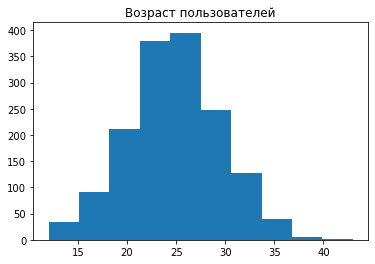

In [32]:
# визуализируем распределение возраста пользователей с помощью гистограммы
plt.hist(users['age'])
plt.title('Возраст пользователей')
plt.show()

Средний возраст пользователя — 25 лет. Больше всего пользователей в диапазоне от приблизительно 22 до 28 лет. Минимальный возраст — 12 лет, максимальный — 43. 

##### Расстояние, которое пользователь преодолел за одну поездку

In [33]:
# получим числовое описание данных по расстоянию 
rides['distance'].describe()

count    17973.000000
mean      3059.863849
std       1108.814623
min          0.860000
25%       2538.840000
50%       3129.030000
75%       3762.640000
max       7066.000000
Name: distance, dtype: float64

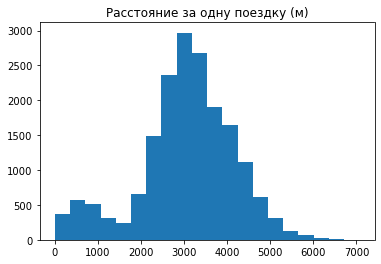

In [34]:
# визуализируем распределение расстояния за поездку с помощью гистограммы
plt.hist(rides['distance'],bins=20)
plt.title('Расстояние за одну поездку (м)')
plt.show()

Среднее расстояние поездки приблизительно 3 км. Чаще всего пользователи проезжали 2-4 км. Минимальное расстояние составило менее 1 метра, при этом на графике видна ощутимая доля поездок на короткие расстояния приблизительно до 700 метров. Возможно, небольшой пик в этой области связан с тем, что пользователи доезжают на самокате до остановки транспорта или до станции метро. 

##### Продолжительность поездок

In [35]:
# получим числовое описание данных по продолжительности 
rides['duration'].describe()

count    17973.000000
mean        17.896486
std          5.975444
min          2.040000
25%         13.670000
50%         17.710000
75%         21.750000
max         40.820000
Name: duration, dtype: float64

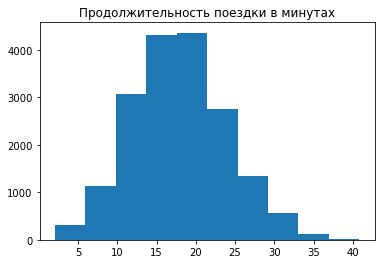

In [36]:
# визуализируем распределение продолжительности поездок с помощью гистограммы
plt.hist(rides['duration'])
plt.title('Продолжительность поездки в минутах')
plt.show()

Средняя продолжительность поездки — около 17 минут. Незначительна доля коротких поездок до 5 минут, минимальная длительность — менее минуты, следовательно, содержатся данные по отменённым поездкам (когда нажали кнопку случайно или передумали ехать почти сразу). Чаще всего пользователи совершали поездки в диапазоне от 13 до 21 минуты. Количество поездок больше 25 минут резко снижается до максимального значения в 40 минут. 

## 4. Объединение данных

##### Объединение данных о пользователях, поездках и подписках в один датафрейм

In [37]:
# объединим с помощью метода merge
data = users.merge(rides,on='user_id',how='right')
data = data.merge(subscriptions,on='subscription_type',how='left')
data.shape[0] == rides.shape[0]

True

##### Создание датафреймов по типам подписки

In [38]:
# используем метод loc для фильтрации
free_users = data.loc[data['subscription_type'] == 'free']
ultra_users = data.loc[data['subscription_type'] == 'ultra']

##### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий


In [39]:
# выведем числовое описание данных по расстоянию
stats = pd.concat([free_users['distance'].describe(),ultra_users['distance'].describe()],axis=1).round(2)
stats.columns = ['Расстояние без подписки', 'и с подпиской Ultra']
stats

,Расстояние без подписки,и с подпиской Ultra
count,11473.00,6500.00
mean,3028.37,3115.45
std,1235.54,836.90
min,0.86,244.21
25%,2360.88,2785.45
50%,3102.08,3148.64
75%,3883.98,3560.58
max,7066.00,5699.77


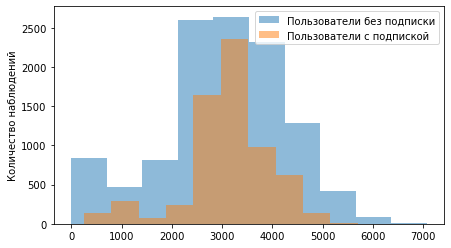

In [40]:
# создаем гистограммы для данных по двум категориям
plt.figure(figsize=(7, 4))
plt.hist(free_users['distance'], alpha=0.5, label='Пользователи без подписки')
plt.hist(ultra_users['distance'], alpha=0.5, label='Пользователи с подпиской')

# добавляем название осей и заголовок графика
plt.ylabel('Количество наблюдений')

# добавляем легенду
plt.legend()

# выводим график
plt.show()

Пользователи с подпиской в среднем проезжают большее расстояние, чем пользователи без подписки. При этом на графике видно, что большая часть значений по длительности поездки с подпиской лежит в диапазоне больше 2 км, пик на коротких поездках — маленький, а без подписки — существенный пик на коротких поездках до 1 км. Возможно, это связано с тем, что пользователи с подпиской чаще ездят на более далёкие расстояния и на постоянной основе, в то время как пользователи без подписки чаще ездят спонтанно, когда нужно ускориться на маленьких расстояниях. 

In [41]:
# выведем числовое описание данных по расстоянию
stats1 = pd.concat([free_users['duration'].describe(),ultra_users['duration'].describe()],axis=1).round(2)
stats1.columns = ['Длительность без подписки', 'и с подпиской Ultra']
stats1

,Длительность без подписки,и с подпиской Ultra
count,11473.00,6500.00
mean,17.53,18.54
std,6.16,5.57
min,2.04,3.76
25%,13.09,14.53
50%,17.38,18.18
75%,21.64,21.88
max,34.95,40.82


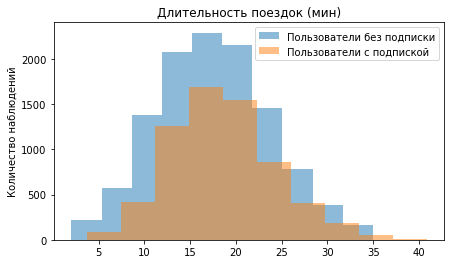

In [42]:
# создаем гистограммы для данных по двум категориям
plt.figure(figsize=(7, 4))
plt.hist(free_users['duration'], alpha=0.5, label='Пользователи без подписки')
plt.hist(ultra_users['duration'], alpha=0.5, label='Пользователи с подпиской')

# добавляем название осей и заголовок графика
plt.ylabel('Количество наблюдений')
plt.title('Длительность поездок (мин)')

# добавляем легенду
plt.legend()

# выводим график
plt.show()

В среднем пользователи с подпиской ездят на ~1 минуту дольше, чем пользователи без подписки. На графике также видно, что данные о пользователях с подпиской смещены вправо относительно данных о пользователях без подписки. То есть в целом пользователи с подпиской не ездят меньше ~4 минут и ездят вплоть до ~40 минут в отличие от пользователей без подписки, у которых диапазон от 0.5 до 35 минут.

## 5. Подсчёт выручки

Cоздадим датафрейм с информацией по поездкам каждого пользователя за каждый месяц, включая количество поездок (считаем по любому столбцу количество строк), суммарные расстояния и длительности.

In [43]:
# округлим длительность поездок до целой минуты
data['duration'] = data['duration'].apply(lambda x : math.ceil(x))

In [44]:
# создадим датафрейм с агрегированными данными о поездках
users_agg = data.groupby(['user_id', 'month']).agg(
    {'date':'count', 'distance':'sum', 'duration':'sum', 
     'subscription_type': 'first' , 'minute_price' : 'first', 'start_ride_price' : 'first', 'subscription_fee' : 'first'}
).reset_index()

# переименуем столбец для удобства
users_agg.rename(columns = {'date':'count'}, inplace = True)

# посмотрим, что получилось (в тч количество строк)
users_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11300 entries, 0 to 11299
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11300 non-null  int64  
 1   month              11300 non-null  int64  
 2   count              11300 non-null  int64  
 3   distance           11300 non-null  float64
 4   duration           11300 non-null  int64  
 5   subscription_type  11300 non-null  object 
 6   minute_price       11300 non-null  int64  
 7   start_ride_price   11300 non-null  int64  
 8   subscription_fee   11300 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 794.7+ KB


Теперь нам нужно посчитать выручку для каждого месяца по каждому пользователю. 

In [45]:
# убедимся, что нет пропусков
users_agg.isna().sum()

user_id              0
month                0
count                0
distance             0
duration             0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [46]:
# посчитаем выручку
users_agg['revenue'] = (users_agg['count'] * users_agg['start_ride_price']) + (users_agg['duration'] * users_agg['minute_price']) + users_agg['subscription_fee']

# удалим лишние столбцы
users_agg.drop(['minute_price', 'start_ride_price', 'subscription_fee'], axis=1, inplace=True)

In [47]:
# выведем первые строчки, чтобы посмотреть результат
users_agg.head()

,user_id,month,count,distance,duration,subscription_type,revenue
0,1,1,2,7027.51,42,ultra,451
1,1,4,1,754.16,7,ultra,241
2,1,8,2,6723.47,46,ultra,475
3,1,10,2,5809.91,32,ultra,391
4,1,11,3,7003.50,56,ultra,535


## 6. Проверка гипотез

Предположительно, пользователи, которые оформили подписку, приносят больше выгоды компании: они платят за подписку и в целом больше (дольше) ездят на самокатах. Однако нужно посмотреть внимательнее на показатели выручки (компенсирует ли платная подписка отсутствие стартовой цены поездки) и на показатели износа самоката (если пользователи ездят дольше по времени, значит предположительно и на большие расстояния, то есть сильнее изнашивают самокаты). Разобъем это рассуждение на серию гипотез.

##### Тратят ли пользователи с подпиской больше времени на поездки?

Проверим гипотезу, что обладатели подписки `ultra` тратят больше времени на поездки, чем пользователи без подписки (`free`).

**Нулевая гипотеза**: средние значения длительности поездки пользователей из двух групп (с подпиской и без) равны. <br/>
**Альтернативная гипотеза**: средние значения длительности поездки пользователей с подпиской *больше*, чем без нее.

In [48]:
# посмотрим на разницу средних значений 'duration' для двух подписок
print('Пользователи с подпиской ездят в среднем на',
      ultra_users['duration'].mean() - free_users['duration'].mean(), 'минут дольше, чем пользователи без подписки')

Пользователи с подпиской ездят в среднем на 1.0112551345298222 минут дольше, чем пользователи без подписки


In [49]:
# проведем ttest для двух выборок, берём одностороннюю гипотезу "больше"
results = st.ttest_ind(ultra_users['duration'], free_users['duration'], alternative='greater')
print('p-значение:', results.pvalue)

# задачем уровень статистической значимости 5%
alpha = 0.05
# если p-value окажется меньше него, отвергнем гипотезу

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.68327274119323e-28
Отвергаем нулевую гипотезу


Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. А ниже мы выясним, действительно ли пользователи с подпиской «выгоднее» для компании: необходимо учитывать износ самокатов и выручку.

##### Укладываются ли пользователи с подпиской в оптимальное значение расстояния поездки для износа самоката? 

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим, можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает это значение.

**Нулевая гипотеза**: среднее значение расстояния поездок пользователей с подпиской Ultra больше 3130 метров. <br/>
**Альтернативная гипотеза**: среднее значение расстояния поездок пользователей с подпиской Ultra меньше или равно 3130 метров.

In [50]:
# введем переменную с оптимальным значением расстояния
opt = 3130

# сравним среднее значение с оптимальным 
ultra_users['distance'].mean() <= opt

True

In [51]:
# код ревьюера
ultra_users['distance'].describe()

count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

In [52]:
# сравним медиану с оптимальным значением
ultra_users['distance'].median() <= opt

False

Поскольку медиана более показательна, чем среднее значение, можно сделать вывод, что пользователи часто проезжают больше, чем 3130 м. Теперь произведём проверку гипотезы. 

In [53]:
# проведем ttest для одной выборки, берём одностороннюю гипотезу "больше"
results1 = st.ttest_1samp(ultra_users['distance'], opt, alternative='less')
print('p-значение:', results1.pvalue)

if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.08046373941575857
Не получилось отвергнуть нулевую гипотезу


Нет оснований говорить, что среднее расстояние поездок пользователей с подпиской не превышает оптимальное значение для износа самоката. То есть по данной выборке можем говорить, что самокат они изнашивают. Однако p-value ~0.08 находится близко к уровню статистической значимости, следовательно, гипотезу лучше еще раз проверить на большей выборке.

##### Сравнение помесячной выручки от пользователей с разными типами подписки по месяцам

In [54]:
# отфильтруем датафрейм с месячной выручкой по типу подписки
free = users_agg.query('subscription_type == "free"')
ultra = users_agg.query('subscription_type == "ultra"')

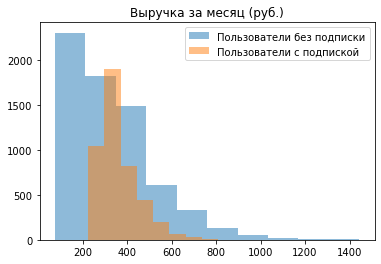

In [55]:
# создаем гистограммы для данных по двум категориям
plt.hist(free['revenue'], alpha=0.5, label='Пользователи без подписки')
plt.hist(ultra['revenue'], alpha=0.5, label='Пользователи с подпиской')

# добавляем название осей и заголовок графика
plt.title('Выручка за месяц (руб.)')

# добавляем легенду
plt.legend()

# выводим график
plt.show()

Посчитаем разницу между средней ежемесячной выручкой от пользователя с подпиской и пользователя без подписки.

In [56]:
# сравним средние значения 'revenue' для двух подписок
revenue = ultra['revenue'].mean() - free['revenue'].mean()
print('Средняя выручка без подписки:', round(free['revenue'].mean(), 2), 'рублей')
print('Средняя выручка с подпиской:', round(ultra['revenue'].mean(), 2), 'рублей')
print('С подпиской больше на', round(revenue, 2), 'рублей')

Средняя выручка без подписки: 329.27 рублей
Средняя выручка с подпиской: 362.73 рублей
С подпиской больше на 33.46 рублей


Средняя выручка от пользователей с подпиской оказалась больше. Теперь проверим гипотезу.

**Нулевая гипотеза**: среднее значение месячной выручки от пользователей с двумя типами подписки равно. <br/>
**Альтернативная гипотеза**: среднее значение месячной выручки от пользователей с подпиской больше, чем от пользователей без подписки.

In [57]:
# проведем ttest для двух выборок, берём одностороннюю гипотезу "больше"
results2 = st.ttest_ind(ultra['revenue'], free['revenue'], alternative='greater')
print('p-значение:', results.pvalue)

if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.68327274119323e-28
Отвергаем нулевую гипотезу


Есть основания говорить, что в среднем ежемесячно пользователи с подпиской приносят больше выручки, чем пользователи без подписки.

Суммируем результаты проверки гипотез. Есть основания утверждать, что пользователи с подпиской в среднем ездят дольше, чем без подписки. При этом среднее расстояние поездок у таких пользователей больше оптимального, что может повлять на износ техники и, следовательно, на затраты по её обслуживанию. Тем не менее, пользователи с подпиской приносят больше выручки, чем, вероятно, компенсируют эти затраты, а также они могут принести большую выгоду компании в будущем. На данный момент можно сказать, что такие пользователи выгодны компании. 

Но важно учитывать, что в целом для оценки выгодности необходимо учитывать разные факторы: точную стоимость износа самоката, затраты на маркетинг и рекламу подписки, и так далее. Рекомендуется также провести повторную проверку гипотезы о превышении оптимального значения расстояния для износа самоката на большей выборке.

## 7. Выводы

Были проанализированы данные по поездкам пользователей с разным типом подписки. В результате предобработки данных были удалены явные дубликаты и поездки с аномально высокой скоростью, пропуски не были обнаружены.

Дальше были исследованы и визуализированы основные параметры: частота встречаемости городов (чаще всего — Пятигорск 14.3%, реже всего — Москва 11.0%), соотношение пользователей с подпиской (45.6%) и без подписки (54.4%), возраст пользователей (больше всего 22-28 лет), расстояние, которое пользователь преодолел за одну поездку (чаще всего (2-4 км), продолжительность поездок (чаще всего 13-21 мин).

А также отдельно исследовано соотношение по расстоянию и длительности для двух типов подписки: пользователи с подпиской в среднем ездят дольше по времени и на большие расстояния. Далее была рассчитана ежемесячная выручка по пользователям.

В результате проверки гипотез было установлено, что пользователи с подпиской действительно более выгодные для компании. Однако рекомендовано провести расчеты с большим количеством параметров и на большей выборке.